<a href="https://colab.research.google.com/github/dscoool/opencv/blob/main/color_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 객체의 색상을 이용하여 검출

In [1]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
import imutils
import matplotlib.pyplot as plt

In [2]:
# def img_show(title='image', img=None, figsize=(8 ,5)):
#     plt.figure(figsize=figsize)

#     if type(img) == list:
#         if type(title) == list:
#             titles = title
#         else:
#             titles = []

#             for i in range(len(img)):
#                 titles.append(title)

#         for i in range(len(img)):
#             if len(img[i].shape) <= 2:
#                 rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
#             else:
#                 rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

#             plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
#             plt.title(titles[i])
#             plt.xticks([]), plt.yticks([])

#         plt.show()
#     else:
#         if len(img.shape) < 3:
#             rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#         else:
#             rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         plt.imshow(rgbImg)
#         plt.title(title)
#         plt.xticks([]), plt.yticks([])
#         plt.show()

### Function declaration
#### Color 을 판단하는 Function (이 부분을 수정하여 특정 Color만 추출을 하는 기능을 구현할 수도 있습니다.)



In [3]:
def color_label(image, c):
    # 윤곽선에 대한 마스크를 구성한 다음 영역에 대한 평균 L*a*b* 값을 계산
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)
    mean = cv2.mean(image, mask=mask)[:3]

    # 정의한 색상 L*a*b* Array를 loop로 수행하여 L*a*b* 색상 값과 이미지 평균 사이의 거리를 계산하며
    # 최소 거리의 L*a*b* 색상 값을 찾음
    min_dist = (np.inf, None)

    for (i, row) in enumerate(lab_array):
        d = dist.euclidean(row[0], mean)
        if d < min_dist[0]:
            min_dist = (d, i)

    return color_names[min_dist[1]]

### Load Image


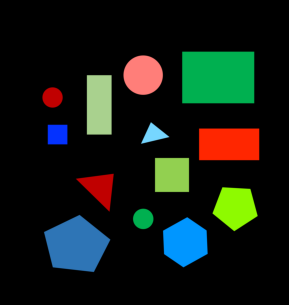

In [7]:
import urllib.request
from google.colab.patches import cv2_imshow

img_url='https://raw.githubusercontent.com/dscoool/opencv/refs/heads/main/color.png'
resp = urllib.request.urlopen(img_url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(image, cv2.IMREAD_COLOR)

cv2_imshow(img)
# img_show('original image', cv2_image)

### Color Detection
#### Key는 색상명, Value는 RGB값을 tuple로 색상 dictionary를 정의합니다.

In [8]:
colors_dict = {"Red": (255, 0, 0),
               "Green": (0, 255, 0),
               "Blue": (0, 0, 255)}

RGB color space를 L*a*b* color space로 변환 (RGB나 HSV가 아닌 L*a*b* 를 이용하는 이유는 선택된 객체의 색상의 어떤 색상과 가까운지 측정하기 위해  유클리디안 거리(Euclidean Distance) 측정 방식을 사용하기 때문입니다.)

In [9]:
lab_array = np.zeros((len(colors_dict), 1, 3), dtype="uint8")
color_names = []

for (i, (name, rgb)) in enumerate(colors_dict.items()):
    lab_array[i] = rgb
    color_names.append(name)

lab_array = cv2.cvtColor(lab_array, cv2.COLOR_RGB2LAB)

아래 과정을 통해 이미지를 그레이스케일로 변환하고 노이즈를 줄이기 위한 이미지 블러링 후 이진화 합니다.

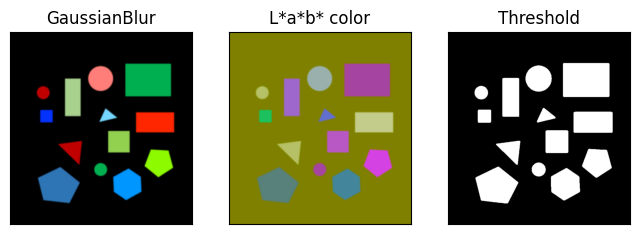

In [11]:
resized = imutils.resize(img, width=640)
ratio = img.shape[0] / float(resized.shape[0])
blurred = cv2.GaussianBlur(resized, (5, 5), 0)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab_img = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]

img_show(['GaussianBlur', 'L*a*b* color', 'Threshold'], [blurred, lab_img, thresh])

이진화 이미지에서 윤곽선을 검출합니다

In [ ]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

추출된 윤곽선을 기준으로 Color을 판단하여 이미지에 표시합니다.



In [ ]:
vis = cv2_image.copy()

# loop over the contours
for c in cnts:
    # cv2.moments를 이용하여 객체의 중심을 계산
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)

    # 이미지에서 객체의 윤곽선과 Color를 표시
    color = color_label(lab_img, c)

    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(vis, [c], -1, (0, 255, 0), 10)
    cv2.circle(vis, (cX, cY), 20, (0, 255, 0), -1);
    cv2.putText(vis, color, (cX-80, cY-50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5)

Color를 표현한 이미지를 확인합니다.



In [12]:
cv2_imshow('Color Detection', vis, figsize=(16,10))


NameError: name 'vis' is not defined

Color Detection을 위해 사용한 L*a*b* 에서 L*는 값의 밝기, a*는 빨강과 초록 중 어느쪽으로 치우쳤는지, *b 는 노랑과 파랑 중 어디로 치우쳤는지를 나타냅니다. L*a*b* 색 공간은 RGB나 CMYK가 표현할 수 있는 모든 색상을 포함하여 나타낼 수 있고 인간이 지각할 수 없는 색상도 나타낼 수 있습니다. 하지만 위에서 우리가 정의한 color_dict의 경계에 모호한 경우는 사람이 인지하는 색상의 분류와 다르게 판단 될 수도 있습니다.

Ref: https://alphalog.co.kr/176
